## Zeroshot from Metric Depth Anything Fine Tunned on Hypersim

In [50]:
import cv2
import torch
import numpy as np
from matplotlib import pyplot as plt

from depth_anything_v2.dpt import DepthAnythingV2

model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]}
}

encoder = 'vitl' # or 'vits', 'vitb'
dataset = 'hypersim' # 'hypersim' for indoor model, 'vkitti' for outdoor model
max_depth = 14 # 20 for indoor model, 80 for outdoor model
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

model = DepthAnythingV2(**{**model_configs[encoder], 'max_depth': max_depth})
model_loaded = torch.load(f'/home/samanta/depth_anything_v2/checkpoints/depth_anything_v2_metric_{dataset}_{encoder}.pth', map_location='cpu')
# model_loaded = torch.load('/home/samanta/depth_anything_v2/metric_depth/exp/fine_tuning_hypersim_decoder_lr_10X/latest.pth', map_location='cpu')['model']
model.load_state_dict(model_loaded)
model.to(DEVICE).eval()

DepthAnythingV2(
  (pretrained): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0): NestedTensorBlock(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (act): GELU()
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
        (ls2

### Fine-tuned Dataset

Raw Image Size:  (480, 640, 3)
Depth Size:  (480, 640)
GT Depth Size:  (480, 640)
Min Raw Image Pixel Value:  0
Max Raw Image Pixel Value:  255
Min depth:  0.5347277
Max depth:  3.4340281
Min GT depth:  1.798
Max GT depth:  3.615
RMSE Error:  0.34020847


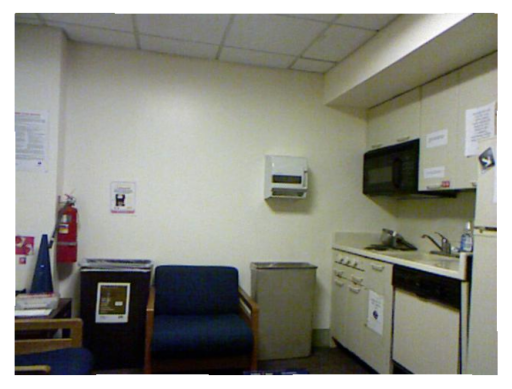

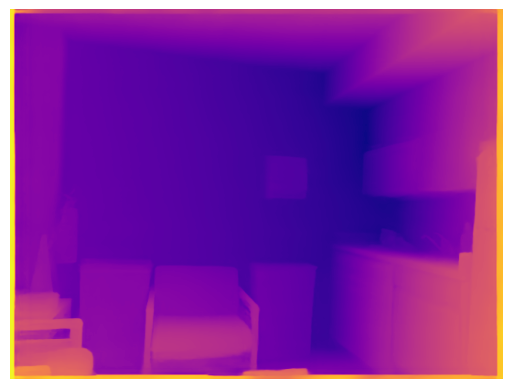

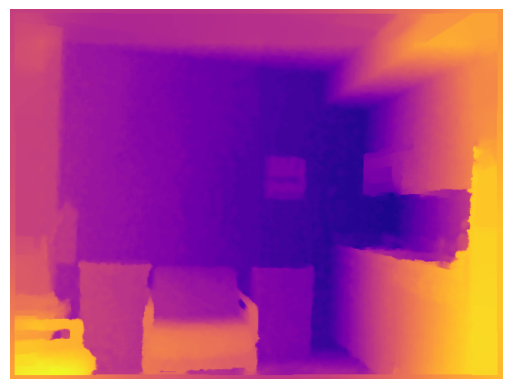

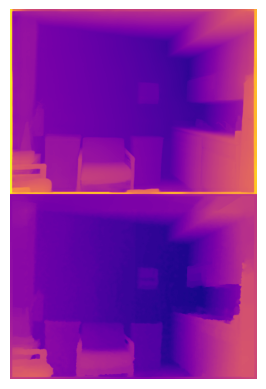

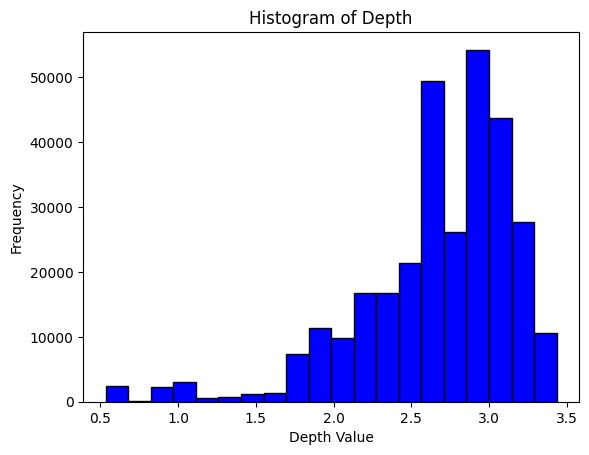

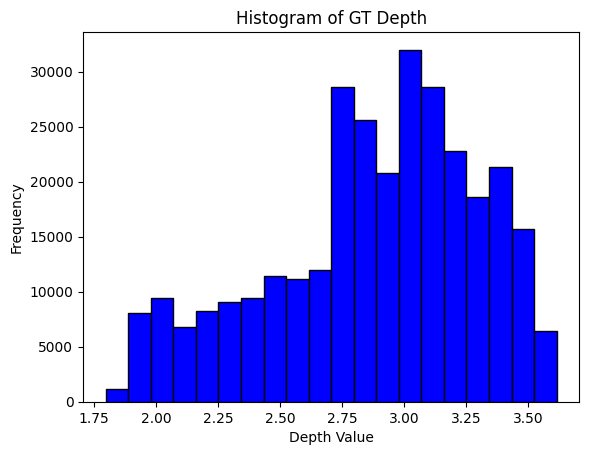

In [51]:
raw_img_path = '/home/samanta/depth_anything_v2/metric_depth/dataset/samples/00000_colors.png'
raw_img = cv2.imread(raw_img_path)
raw_img = cv2.cvtColor(raw_img, cv2.COLOR_RGB2BGR)
depth = model.infer_image(raw_img) # HxW raw depth map in numpy

raw_depth_path = '/home/samanta/depth_anything_v2/metric_depth/dataset/samples/00000_depth.png'
gt_depth = cv2.imread(raw_depth_path, cv2.IMREAD_UNCHANGED).astype(np.float32)
# gt_depth = np.load(raw_depth_path)
H, W = depth.shape[:2]
gt_depth = gt_depth.reshape(H, W)/1000 # In meters
# gt_depth = np.clip(gt_depth, 0.0, 7.0)

print('Raw Image Size: ', raw_img.shape)
print('Depth Size: ', depth.shape)
print('GT Depth Size: ', gt_depth.shape)
print('Min Raw Image Pixel Value: ', np.min(raw_img))
print('Max Raw Image Pixel Value: ', np.max(raw_img))
print('Min depth: ', np.min(depth))
print('Max depth: ', np.max(depth))
print('Min GT depth: ', np.min(gt_depth))
print('Max GT depth: ', np.max(gt_depth))

plt.figure()
plt.axis('off')
plt.imshow(raw_img)

plt.figure()
plt.axis('off')
plt.imshow(depth, cmap='plasma_r')

gt_depth[gt_depth >= 6.0] = 7.0
plt.figure()
plt.axis('off')
plt.imshow(gt_depth, cmap='plasma_r')

depths_cat = np.concatenate([depth, gt_depth], axis=0)
rmse_error = np.sqrt(np.mean((depth - gt_depth)**2))
print('RMSE Error: ', rmse_error)
plt.figure()
plt.axis('off')
plt.imshow(depths_cat, cmap='plasma_r')

plt.figure()
plt.hist(depth.flatten(), bins=20, color='blue', edgecolor='black')
plt.title('Histogram of Depth')
plt.xlabel('Depth Value')
plt.ylabel('Frequency')
plt.show()

plt.figure()
plt.hist(gt_depth.flatten()[gt_depth.flatten() < 100000], bins=20, color='blue', edgecolor='black')
plt.title('Histogram of GT Depth')
plt.xlabel('Depth Value')
plt.ylabel('Frequency')
plt.show()

### Our Dataset

Raw Image Size:  (720, 1280, 3)
Depth Size:  (720, 1280)
GT Depth Size:  (720, 1280)
Min Raw Image Pixel Value:  0
Max Raw Image Pixel Value:  255
Min depth:  0.37630188
Max depth:  5.0722413
Min GT depth:  0.0
Max GT depth:  7.0
RMSE Error:  0.32349318961355694


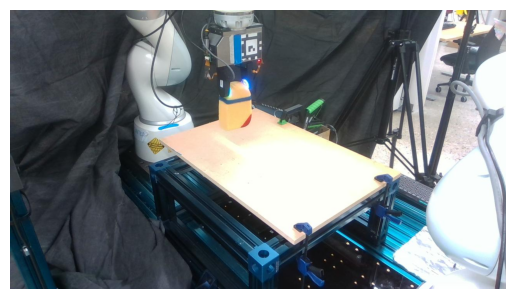

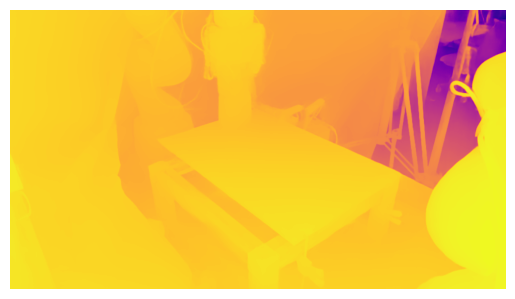

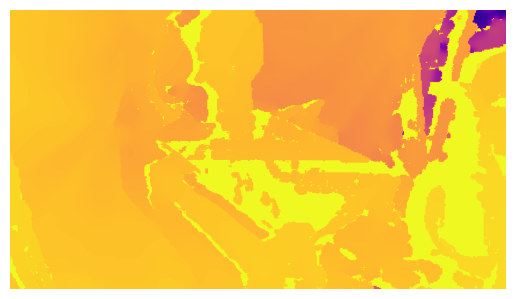

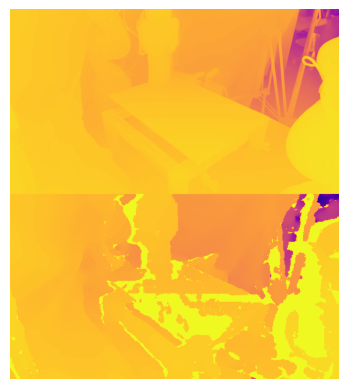

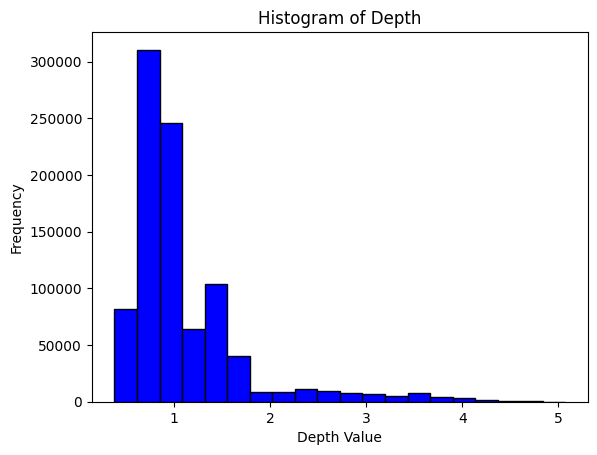

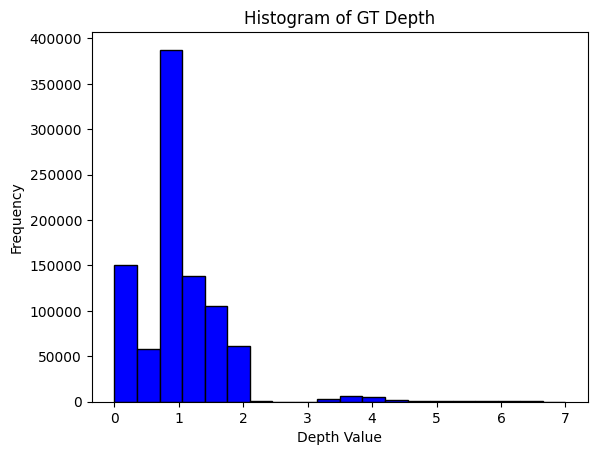

In [52]:
raw_img_path = '/home/samanta/tactile_4D_gaussian_splatting/data_dynamic/sponge_painted_deformable_capture/dynamic/videos_images/C0733/DSC_0002.JPG'
raw_img = cv2.imread(raw_img_path)
raw_img = cv2.cvtColor(raw_img, cv2.COLOR_RGB2BGR)
depth = model.infer_image(raw_img) # HxW raw depth map in numpy

raw_depth_path = '/home/samanta/tactile_4D_gaussian_splatting/data_dynamic/sponge_painted_deformable_capture/dynamic/videos_depth/C0733/DSC_0002.npy'
gt_depth = np.load(raw_depth_path)
H, W = depth.shape[:2]
gt_depth = gt_depth.reshape(H, W)/1000 # In meters
gt_depth = np.clip(gt_depth, 0.0, 7.0)

print('Raw Image Size: ', raw_img.shape)
print('Depth Size: ', depth.shape)
print('GT Depth Size: ', gt_depth.shape)
print('Min Raw Image Pixel Value: ', np.min(raw_img))
print('Max Raw Image Pixel Value: ', np.max(raw_img))
print('Min depth: ', np.min(depth))
print('Max depth: ', np.max(depth))
print('Min GT depth: ', np.min(gt_depth))
print('Max GT depth: ', np.max(gt_depth))

plt.figure()
plt.axis('off')
plt.imshow(raw_img)

plt.figure()
plt.axis('off')
plt.imshow(depth, cmap='plasma_r')

plt.figure()
plt.axis('off')
plt.imshow(gt_depth, cmap='plasma_r')

depths_cat = np.concatenate([depth, gt_depth], axis=0)
rmse_error = np.sqrt(np.mean((depth[gt_depth != 0.0] - gt_depth[gt_depth != 0.0])**2))
print('RMSE Error: ', rmse_error)
plt.figure()
plt.axis('off')
plt.imshow(depths_cat, cmap='plasma_r')

plt.figure()
plt.hist(depth.flatten(), bins=20, color='blue', edgecolor='black')
plt.title('Histogram of Depth')
plt.xlabel('Depth Value')
plt.ylabel('Frequency')
plt.show()

plt.figure()
plt.hist(gt_depth.flatten()[gt_depth.flatten() < 100000], bins=20, color='blue', edgecolor='black')
plt.title('Histogram of GT Depth')
plt.xlabel('Depth Value')
plt.ylabel('Frequency')
plt.show()

Raw Image Size:  (720, 1280, 3)
Depth Size:  (720, 1280)
GT Depth Size:  (720, 1280)
Min Raw Image Pixel Value:  0
Max Raw Image Pixel Value:  255
Min depth:  0.48073947
Max depth:  5.53494
Min GT depth:  0.0
Max GT depth:  6.0
RMSE Error:  0.3761020865853212


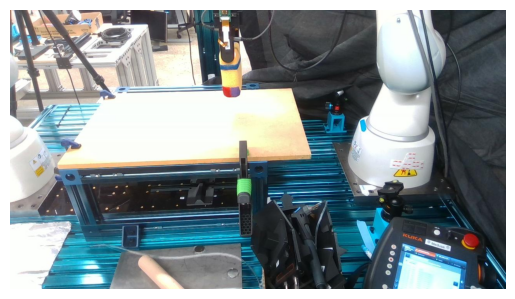

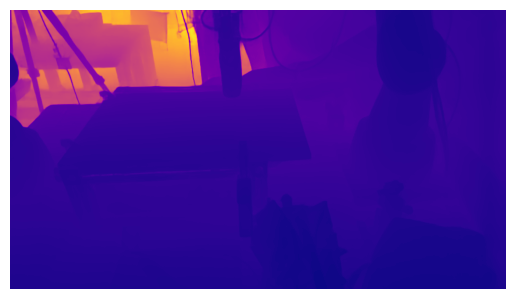

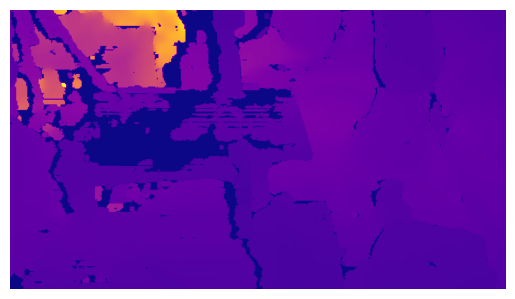

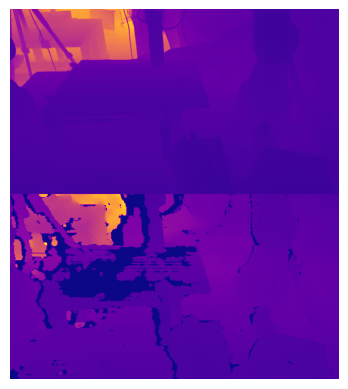

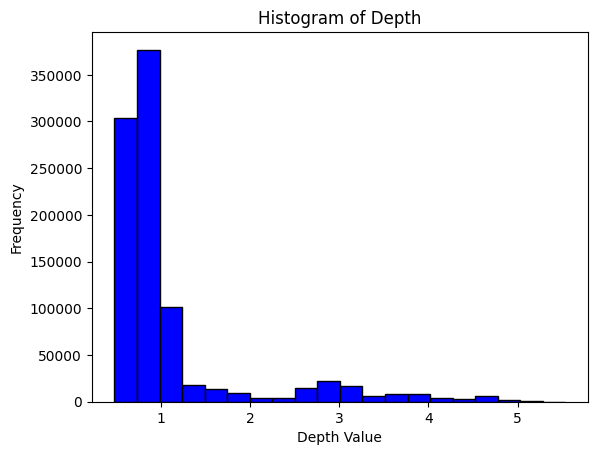

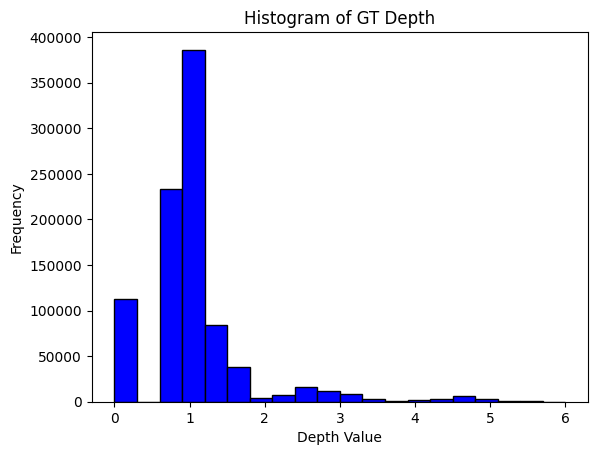

In [53]:
raw_img_path = '/home/samanta/tactile_4D_gaussian_splatting/data_dynamic/sponge_painted_deformable_capture/dynamic/videos_images/C0787/DSC_0002.JPG'
raw_img = cv2.imread(raw_img_path)
raw_img = cv2.cvtColor(raw_img, cv2.COLOR_RGB2BGR)
depth = model.infer_image(raw_img) # HxW raw depth map in numpy

raw_depth_path = '/home/samanta/tactile_4D_gaussian_splatting/data_dynamic/sponge_painted_deformable_capture/dynamic/videos_depth/C0787/DSC_0002.npy'
gt_depth = np.load(raw_depth_path)
H, W = depth.shape[:2]
gt_depth = gt_depth.reshape(H, W)/1000 # In meters
gt_depth = np.clip(gt_depth, 0.0, 6.0)

print('Raw Image Size: ', raw_img.shape)
print('Depth Size: ', depth.shape)
print('GT Depth Size: ', gt_depth.shape)
print('Min Raw Image Pixel Value: ', np.min(raw_img))
print('Max Raw Image Pixel Value: ', np.max(raw_img))
print('Min depth: ', np.min(depth))
print('Max depth: ', np.max(depth))
print('Min GT depth: ', np.min(gt_depth))
print('Max GT depth: ', np.max(gt_depth))

plt.figure()
plt.axis('off')
plt.imshow(raw_img)

plt.figure()
plt.axis('off')
plt.imshow(depth, cmap='plasma')

plt.figure()
plt.axis('off')
plt.imshow(gt_depth, cmap='plasma')

depths_cat = np.concatenate([depth, gt_depth], axis=0)
rmse_error = np.sqrt(np.mean((depth[gt_depth != 0.0] - gt_depth[gt_depth != 0.0])**2))
print('RMSE Error: ', rmse_error)
plt.figure()
plt.axis('off')
plt.imshow(depths_cat, cmap='plasma')

plt.figure()
plt.hist(depth.flatten(), bins=20, color='blue', edgecolor='black')
plt.title('Histogram of Depth')
plt.xlabel('Depth Value')
plt.ylabel('Frequency')
plt.show()

plt.figure()
plt.hist(gt_depth.flatten()[gt_depth.flatten() < 100000], bins=20, color='blue', edgecolor='black')
plt.title('Histogram of GT Depth')
plt.xlabel('Depth Value')
plt.ylabel('Frequency')
plt.show()

### GelSLim

Gelslim Image Size:  (320, 427, 3)
Min Gelslim Image Pixel Value:  0.0
Max Gelslim Image Pixel Value:  255.0
Min depth:  0.0014145799
Max depth:  0.0029231154


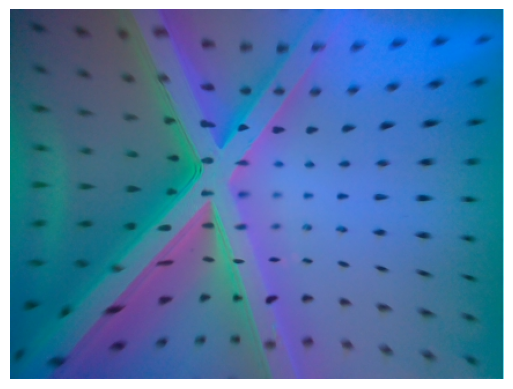

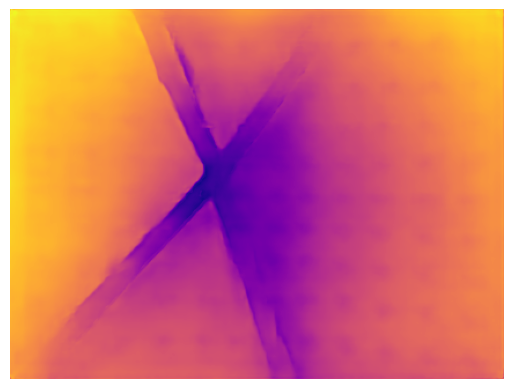

In [59]:
gelsim_path = '/home/samanta/touch2touch/data/test/train_only/gelslims/pattern_02_2_lines_angle_2_data_399.pt'
gelsim_image = torch.load(gelsim_path)['gelslim'][0].permute(1, 2, 0).numpy()
# gelsim_image *= 255
# gelsim_image = (gelsim_image - np.min(gelsim_image)) / (np.max(gelsim_image) - np.min(gelsim_image))
gelsim_image = cv2.cvtColor(gelsim_image, cv2.COLOR_RGB2BGR)
gelsim_depth = model.infer_image(gelsim_image) # HxW raw depth map in numpy

print('Gelslim Image Size: ', gelsim_image.shape)
print('Min Gelslim Image Pixel Value: ', np.min(gelsim_image))
print('Max Gelslim Image Pixel Value: ', np.max(gelsim_image))
print('Min depth: ', np.min(gelsim_depth))
print('Max depth: ', np.max(gelsim_depth))

plt.figure()
plt.axis('off')
gelsim_image_vis = (gelsim_image - np.min(gelsim_image)) / (np.max(gelsim_image) - np.min(gelsim_image))
gelsim_image_vis = cv2.cvtColor(gelsim_image_vis, cv2.COLOR_BGR2RGB)
plt.imshow(gelsim_image_vis)

plt.figure()
plt.axis('off')
plt.imshow(gelsim_depth, cmap='plasma_r')

### Soft Bubble

Bubble Image Size:  (140, 175, 3)
GT Depth Size:  (140, 175)
Min Bubble Image Pixel Value:  0.0
Max Bubble Image Pixel Value:  255.0
Min depth:  0.0018212294
Max depth:  0.0023653177
GT Depth Min:  0.06958558
GT Depth Max:  0.11254777


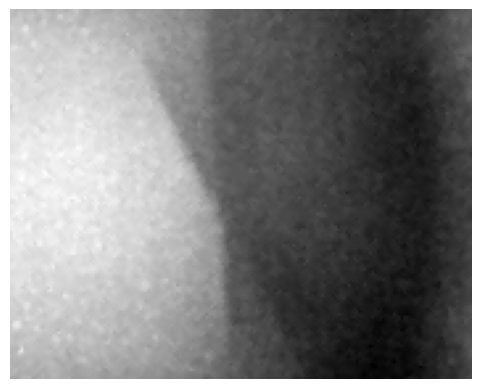

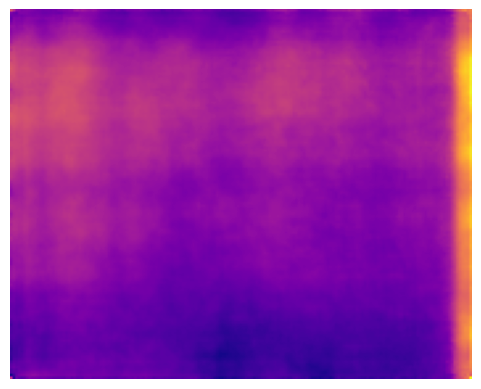

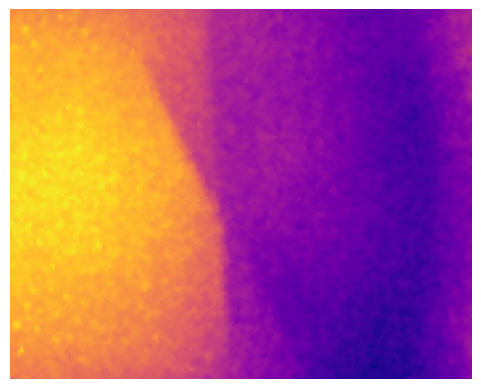

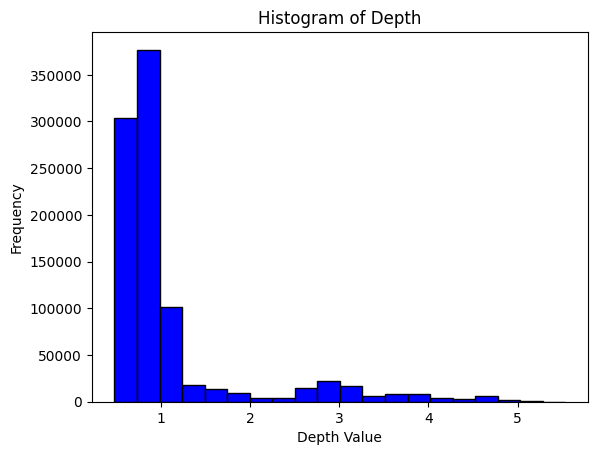

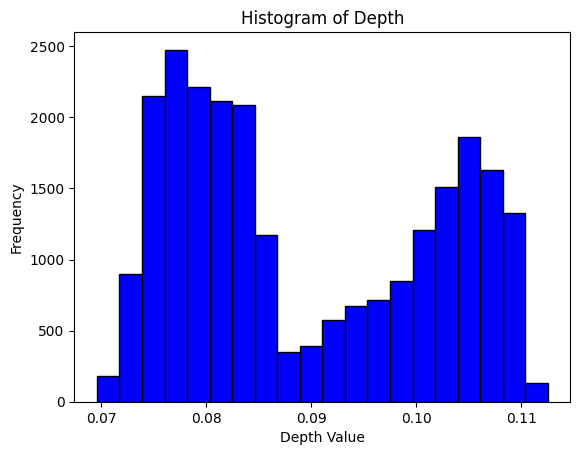

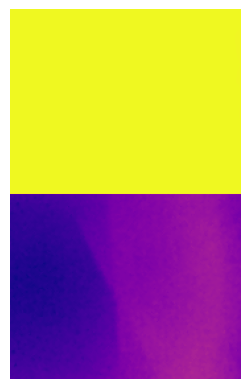

In [60]:
bubble_path = '/home/samanta/touch2touch/data/test/train_only/bubbles/pattern_01_2_lines_angle_1_data_8.pt'
bubble_imprint = torch.load(bubble_path)['bubble_imprint'][0].permute(1, 2, 0).repeat(1, 1, 3).numpy()
bubble_ref = torch.load(bubble_path)['bubble_depth_ref'][0].permute(1, 2, 0).repeat(1, 1, 3).numpy()
bubble_image = bubble_ref - bubble_imprint
bubble_image = (bubble_image - np.min(bubble_image)) / (np.max(bubble_image) - np.min(bubble_image))
bubble_image *= 255
# bubble_image = cv2.cvtColor(bubble_image, cv2.COLOR_RGB2BGR)
bubble_depth = model.infer_image(bubble_image) # HxW raw depth map in numpy
# bubble_depth = 1/np.maximum(bubble_depth, 1e-12) # 200*
# bubble_depth = (bubble_depth - np.min(bubble_depth)) / (np.max(bubble_depth) - np.min(bubble_depth))

gt_depth = bubble_ref[:,:,0] - bubble_imprint[:,:,0]
# gt_depth = 1/gt_depth
# gt_depth = (gt_depth - np.min(gt_depth)) / (np.max(gt_depth) - np.min(gt_depth))

print('Bubble Image Size: ', bubble_image.shape)
print('GT Depth Size: ', gt_depth.shape)
print('Min Bubble Image Pixel Value: ', np.min(bubble_image))
print('Max Bubble Image Pixel Value: ', np.max(bubble_image))
print('Min depth: ', np.min(bubble_depth))
print('Max depth: ', np.max(bubble_depth))
print('GT Depth Min: ', np.min(gt_depth))
print('GT Depth Max: ', np.max(gt_depth))

plt.figure()
plt.axis('off')
plt.imshow(bubble_image[:,:,0]/255, cmap= 'gray') 

plt.figure()
plt.axis('off')
plt.imshow(bubble_depth, cmap='plasma')

plt.figure()
plt.axis('off')
plt.imshow(gt_depth, cmap='plasma')

plt.figure()
plt.hist(depth.flatten(), bins=20, color='blue', edgecolor='black')
plt.title('Histogram of Depth')
plt.xlabel('Depth Value')
plt.ylabel('Frequency')
plt.show()

plt.figure()
plt.hist(gt_depth.flatten(), bins=20, color='blue', edgecolor='black')
plt.title('Histogram of Depth')
plt.xlabel('Depth Value')
plt.ylabel('Frequency')
plt.show()

depths_cat = np.concatenate([bubble_depth, gt_depth], axis=0)
plt.figure()
plt.axis('off')
plt.imshow(depths_cat, cmap='plasma_r')

## Training Fine-tuning on Small Hypersim Dataset with Small Model

In [8]:
import cv2
import torch
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt

from depth_anything_v2.dpt import DepthAnythingV2

model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]}
}

encoder = 'vits' # or 'vits', 'vitb'
dataset = 'hypersim' # 'hypersim' for indoor model, 'vkitti' for outdoor model
max_depth = 1.4 # 20 for indoor model, 80 for outdoor model
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

model = DepthAnythingV2(**{**model_configs[encoder], 'max_depth': max_depth})
# model_loaded = torch.load(f'/home/samanta/depth_anything_v2/checkpoints/depth_anything_v2_metric_{dataset}_{encoder}.pth', map_location='cpu')
model_loaded = torch.load('/home/samanta/depth_anything_v2/metric_depth/exp/fine_tuning_hypersim_decoder_lr_10X/latest.pth', map_location='cpu')['model']
model.load_state_dict(model_loaded)
model.to(DEVICE).eval()

DepthAnythingV2(
  (pretrained): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0): NestedTensorBlock(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU()
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
        (ls2): Layer

### External Image Data

Raw Image Size:  (720, 1280, 3)
Depth Size:  (720, 1280)
GT Depth Size:  (720, 1280)
Min Raw Image Pixel Value:  0
Max Raw Image Pixel Value:  255
Min depth:  0.37106958
Max depth:  3.5605996
Min GT depth:  0.0
Max GT depth:  3.5
RMSE Error:  0.5269370151864442


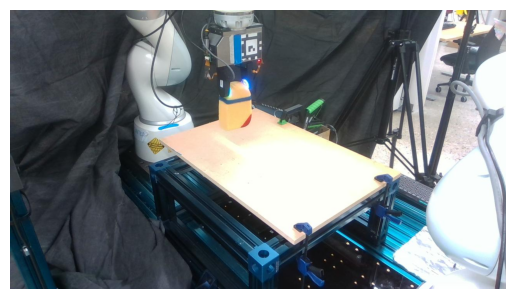

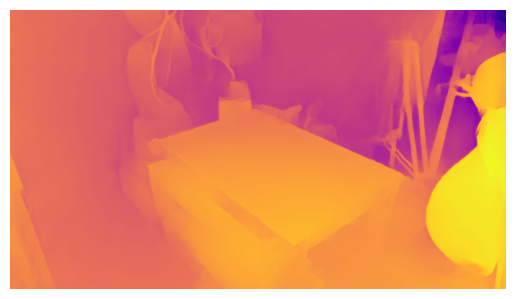

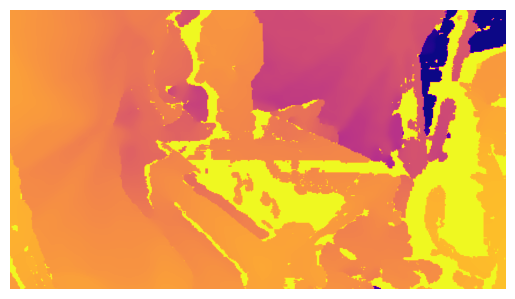

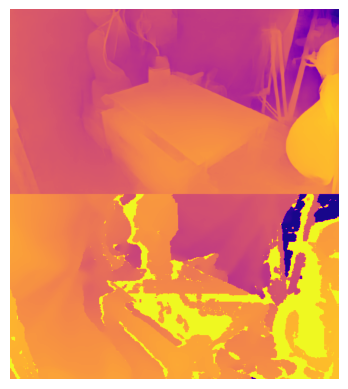

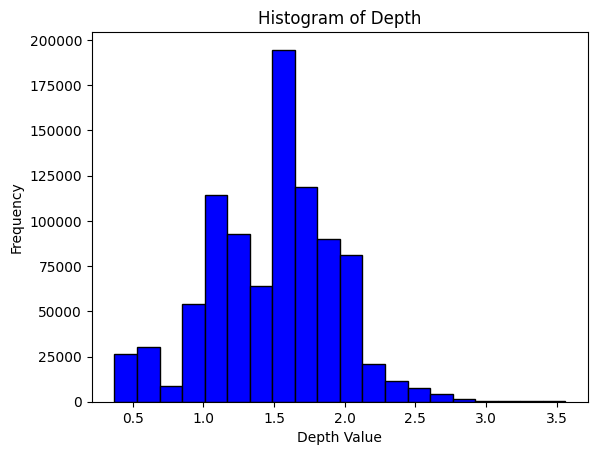

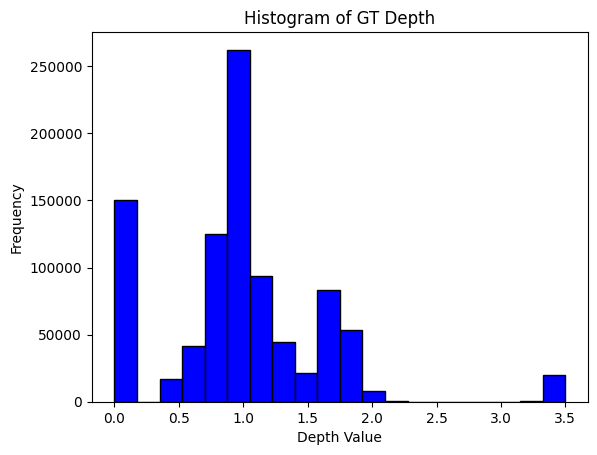

In [80]:
raw_img_path = '/home/samanta/tactile_4D_gaussian_splatting/data_dynamic/sponge_painted_deformable_capture/dynamic/videos_images/C0733/DSC_0002.JPG'
raw_img = cv2.imread(raw_img_path)
raw_img = cv2.cvtColor(raw_img, cv2.COLOR_RGB2BGR)
depth = model.infer_image(raw_img) # HxW raw depth map in numpy

raw_depth_path = '/home/samanta/tactile_4D_gaussian_splatting/data_dynamic/sponge_painted_deformable_capture/dynamic/videos_depth/C0733/DSC_0002.npy'
gt_depth = np.load(raw_depth_path)
H, W = depth.shape[:2]
gt_depth = gt_depth.reshape(H, W)/1000 # In meters
gt_depth = np.clip(gt_depth, 0.0, 3.5)

print('Raw Image Size: ', raw_img.shape)
print('Depth Size: ', depth.shape)
print('GT Depth Size: ', gt_depth.shape)
print('Min Raw Image Pixel Value: ', np.min(raw_img))
print('Max Raw Image Pixel Value: ', np.max(raw_img))
print('Min depth: ', np.min(depth))
print('Max depth: ', np.max(depth))
print('Min GT depth: ', np.min(gt_depth))
print('Max GT depth: ', np.max(gt_depth))

plt.figure()
plt.axis('off')
plt.imshow(raw_img)

plt.figure()
plt.axis('off')
plt.imshow(depth, cmap='plasma_r')

plt.figure()
plt.axis('off')
plt.imshow(gt_depth, cmap='plasma_r')

depths_cat = np.concatenate([depth, gt_depth], axis=0)
rmse_error = np.sqrt(np.mean((depth[gt_depth != 0.0] - gt_depth[gt_depth != 0.0])**2))
print('RMSE Error: ', rmse_error)
plt.figure()
plt.axis('off')
plt.imshow(depths_cat, cmap='plasma_r')

plt.figure()
plt.hist(depth.flatten(), bins=20, color='blue', edgecolor='black')
plt.title('Histogram of Depth')
plt.xlabel('Depth Value')
plt.ylabel('Frequency')
plt.show()

plt.figure()
plt.hist(gt_depth.flatten()[gt_depth.flatten() < 100000], bins=20, color='blue', edgecolor='black')
plt.title('Histogram of GT Depth')
plt.xlabel('Depth Value')
plt.ylabel('Frequency')
plt.show()

In [77]:
import cv2
import torch
import numpy as np
from matplotlib import pyplot as plt

from depth_anything_v2.dpt import DepthAnythingV2

model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]}
}

encoder = 'vits' # or 'vits', 'vitb'
dataset = 'hypersim' # 'hypersim' for indoor model, 'vkitti' for outdoor model
max_depth = 1.4 # 20 for indoor model, 80 for outdoor model
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

model = DepthAnythingV2(**{**model_configs[encoder], 'max_depth': max_depth})
# model_loaded = torch.load(f'/home/samanta/depth_anything_v2/checkpoints/depth_anything_v2_metric_{dataset}_{encoder}.pth', map_location='cpu')
model_loaded = torch.load('/home/samanta/depth_anything_v2/metric_depth/exp/fine_tuning_hypersim_decoder_lr_10X/latest.pth', map_location='cpu')['model']
model.load_state_dict(model_loaded)
model.to(DEVICE).eval()

DepthAnythingV2(
  (pretrained): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0): NestedTensorBlock(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU()
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
        (ls2): Layer

### GelSlim

Gelslim Image Size:  (320, 427, 3)
Min Gelslim Image Pixel Value:  0.0
Max Gelslim Image Pixel Value:  255.0
Min depth:  0.06601372
Max depth:  0.13641205


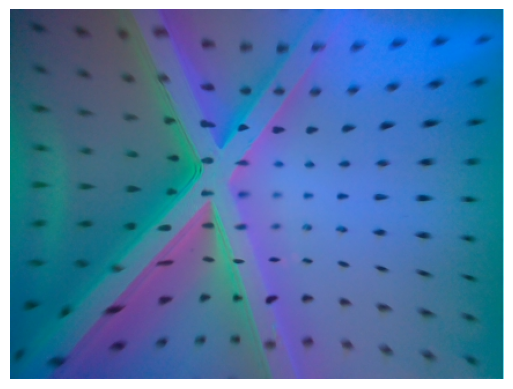

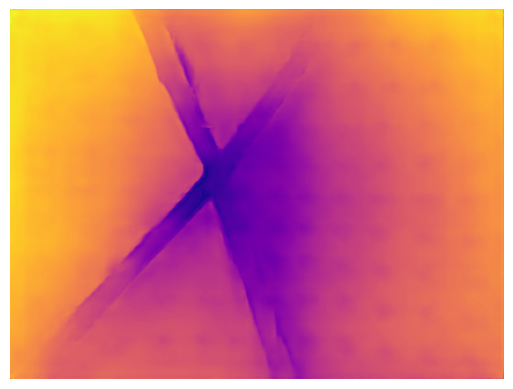

In [75]:
gelsim_path = '/home/samanta/touch2touch/data/test/train_only/gelslims/pattern_02_2_lines_angle_2_data_399.pt'
gelsim_image = torch.load(gelsim_path)['gelslim'][0].permute(1, 2, 0).numpy()
# gelsim_image *= 255
# gelsim_image = (gelsim_image - np.min(gelsim_image)) / (np.max(gelsim_image) - np.min(gelsim_image))
gelsim_image = cv2.cvtColor(gelsim_image, cv2.COLOR_RGB2BGR)
gelsim_depth = model.infer_image(gelsim_image) # HxW raw depth map in numpy

print('Gelslim Image Size: ', gelsim_image.shape)
print('Min Gelslim Image Pixel Value: ', np.min(gelsim_image))
print('Max Gelslim Image Pixel Value: ', np.max(gelsim_image))
print('Min depth: ', np.min(gelsim_depth))
print('Max depth: ', np.max(gelsim_depth))

plt.figure()
plt.axis('off')
gelsim_image_vis = (gelsim_image - np.min(gelsim_image)) / (np.max(gelsim_image) - np.min(gelsim_image))
gelsim_image_vis = cv2.cvtColor(gelsim_image_vis, cv2.COLOR_BGR2RGB)
plt.imshow(gelsim_image_vis)

plt.figure()
plt.axis('off')
plt.imshow(gelsim_depth, cmap='plasma_r')

### Soft Bubble

Bubble Image Size:  (140, 175, 3)
GT Depth Size:  (140, 175)
Min Bubble Image Pixel Value:  0.0
Max Bubble Image Pixel Value:  255.0
Min depth:  0.08499071
Max depth:  0.11038149
GT Depth Min:  0.06958558
GT Depth Max:  0.11254777
RMSE Error:  0.0124607645


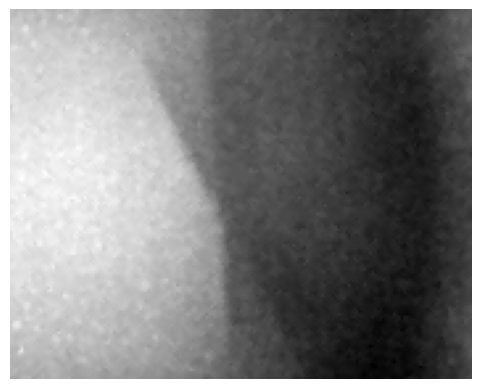

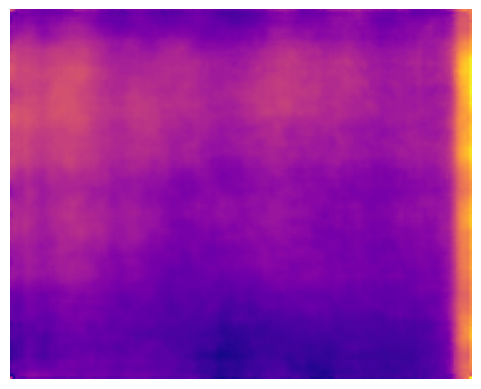

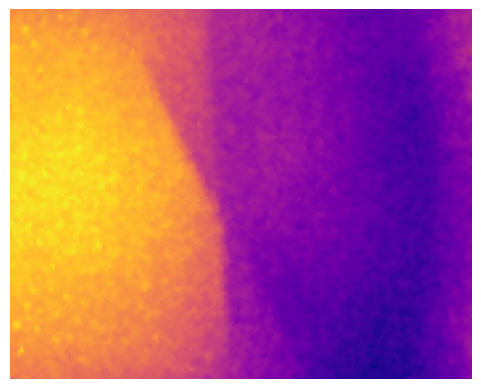

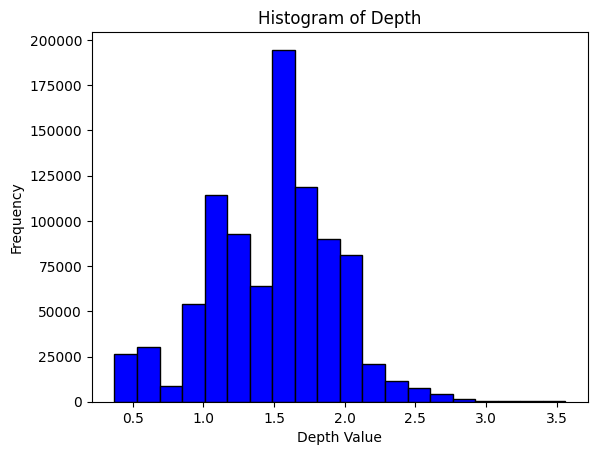

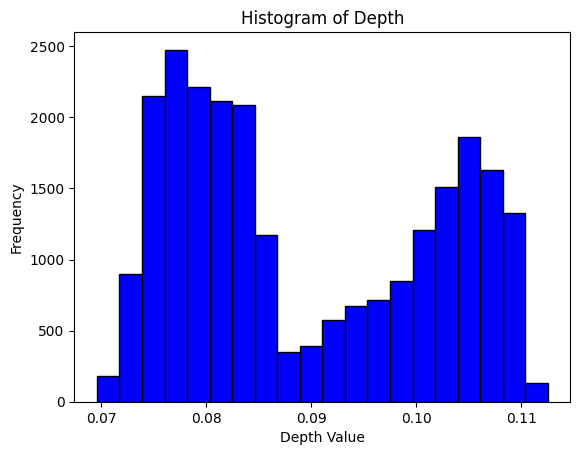

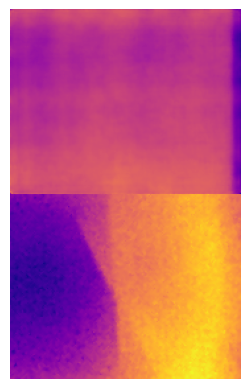

In [85]:
bubble_path = '/home/samanta/touch2touch/data/test/train_only/bubbles/pattern_01_2_lines_angle_1_data_8.pt'
bubble_imprint = torch.load(bubble_path)['bubble_imprint'][0].permute(1, 2, 0).repeat(1, 1, 3).numpy()
bubble_ref = torch.load(bubble_path)['bubble_depth_ref'][0].permute(1, 2, 0).repeat(1, 1, 3).numpy()
bubble_image = bubble_ref - bubble_imprint
bubble_image = (bubble_image - np.min(bubble_image)) / (np.max(bubble_image) - np.min(bubble_image))
bubble_image *= 255
# bubble_image = cv2.cvtColor(bubble_image, cv2.COLOR_RGB2BGR)
bubble_depth = model.infer_image(bubble_image) # HxW raw depth map in numpy
# bubble_depth = 1/np.maximum(bubble_depth, 1e-12) # 200*
# bubble_depth = (bubble_depth - np.min(bubble_depth)) / (np.max(bubble_depth) - np.min(bubble_depth))

gt_depth = bubble_ref[:,:,0] - bubble_imprint[:,:,0]
# gt_depth = 1/gt_depth
# gt_depth = (gt_depth - np.min(gt_depth)) / (np.max(gt_depth) - np.min(gt_depth))

print('Bubble Image Size: ', bubble_image.shape)
print('GT Depth Size: ', gt_depth.shape)
print('Min Bubble Image Pixel Value: ', np.min(bubble_image))
print('Max Bubble Image Pixel Value: ', np.max(bubble_image))
print('Min depth: ', np.min(bubble_depth))
print('Max depth: ', np.max(bubble_depth))
print('GT Depth Min: ', np.min(gt_depth))
print('GT Depth Max: ', np.max(gt_depth))

rmse_error = np.sqrt(np.mean((bubble_depth[gt_depth != 0.0] - gt_depth[gt_depth != 0.0])**2))
print('RMSE Error: ', rmse_error)

plt.figure()
plt.axis('off')
plt.imshow(bubble_image[:,:,0]/255, cmap= 'gray') 

plt.figure()
plt.axis('off')
plt.imshow(bubble_depth, cmap='plasma')

plt.figure()
plt.axis('off')
plt.imshow(gt_depth, cmap='plasma')

plt.figure()
plt.hist(depth.flatten(), bins=20, color='blue', edgecolor='black')
plt.title('Histogram of Depth')
plt.xlabel('Depth Value')
plt.ylabel('Frequency')
plt.show()

plt.figure()
plt.hist(gt_depth.flatten(), bins=20, color='blue', edgecolor='black')
plt.title('Histogram of Depth')
plt.xlabel('Depth Value')
plt.ylabel('Frequency')
plt.show()

depths_cat = np.concatenate([bubble_depth, gt_depth], axis=0)
plt.figure()
plt.axis('off')
plt.imshow(depths_cat, cmap='plasma_r')

## Depth Anything Fine Tunned on Bubble Images

In [2]:
import cv2
import torch
import numpy as np
from matplotlib import pyplot as plt

from depth_anything_v2.dpt import DepthAnythingV2

model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]}
}

encoder = 'vits' # or 'vits', 'vitb'
dataset = 'bubbles' # 'hypersim' for indoor model, 'vkitti' for outdoor model
max_depth = 0.1 # 20 for indoor model, 80 for outdoor model
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

model = DepthAnythingV2(**{**model_configs[encoder], 'max_depth': max_depth})
model_loaded = torch.load('/home/samanta/depth_anything_v2/metric_depth/exp/fine_tuning_bubbles_imprint_max0.1/latest.pth', map_location='cpu')['model']
model.load_state_dict(model_loaded)
model.to(DEVICE).eval()

xFormers not available
xFormers not available


DepthAnythingV2(
  (pretrained): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0): NestedTensorBlock(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU()
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
        (ls2): Layer

Bubble Image Size:  (140, 175, 3)
Bubble Depth Size:  torch.Size([140, 175])
Bubble Image Size:  (1, 3, 518, 644)
GT Depth Size:  (140, 175)
Min Bubble Image Pixel Value:  -2.1236868
Max Bubble Image Pixel Value:  2.6596394
Min depth:  0.06940679
Max depth:  0.099995196
GT Depth Min:  -0.00543537
GT Depth Max:  0.019316614
RMSE Error:  0.08665095


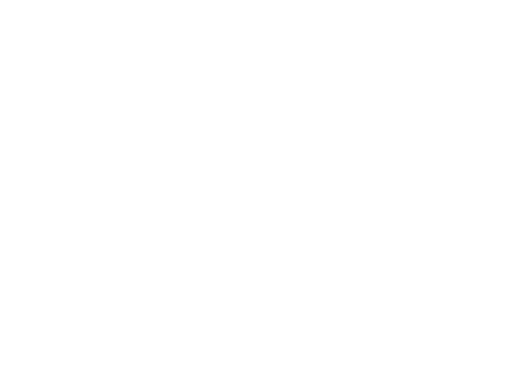

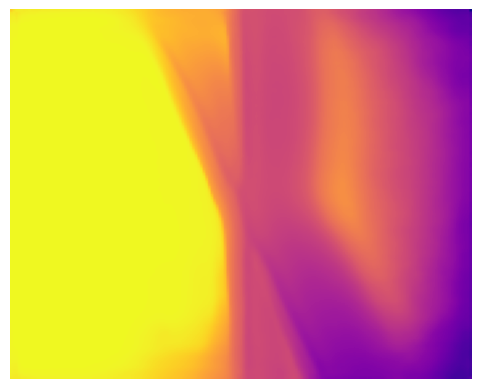

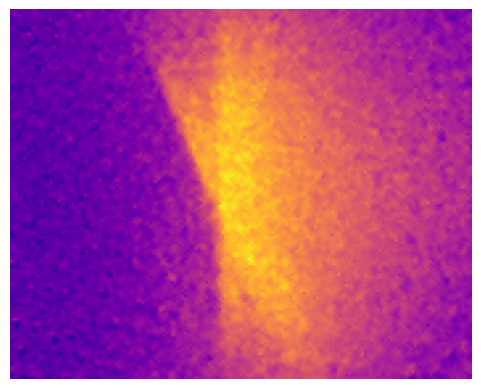

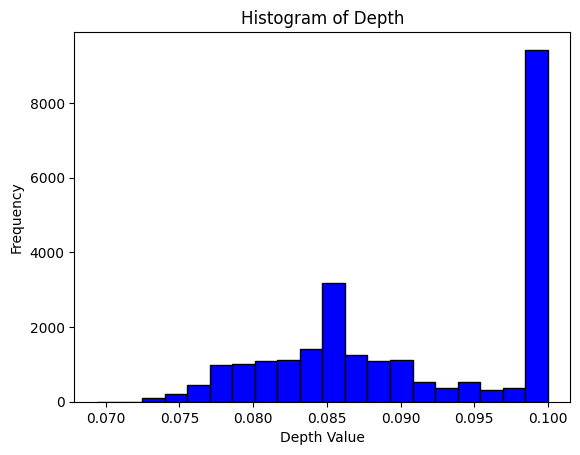

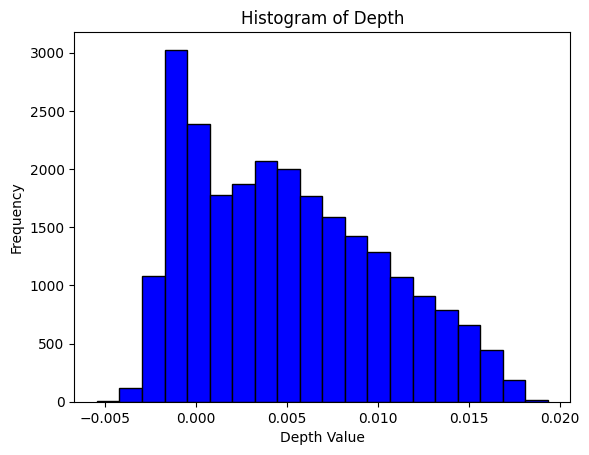

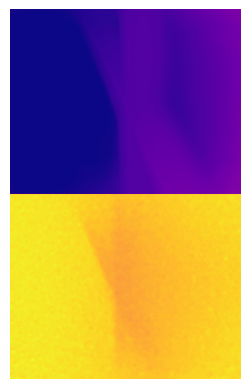

In [3]:
from dataset.transform import Resize, NormalizeImage, PrepareForNet
from torchvision.transforms import Compose
import torch.nn.functional as F

transform = Compose([
            Resize(
                width=518,
                height=518,
                resize_target=False,
                keep_aspect_ratio=True,
                ensure_multiple_of=14,
                resize_method='lower_bound',
                image_interpolation_method=cv2.INTER_CUBIC,
            ),
            NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            PrepareForNet(),
        ])
bubble_path = '/home/samanta/T2D2T/data/test_only/bubbles/pattern_01_2_lines_angle_1_data_10.pt'
bubble_imprint = torch.load(bubble_path)['bubble_imprint'][0].permute(1, 2, 0).repeat(1, 1, 3)
bubble_ref = torch.load(bubble_path)['bubble_depth_ref'][0].permute(1, 2, 0).repeat(1, 1, 3)
# bubble_image = bubble_ref - bubble_imprint
bubble_image = bubble_imprint
bubble_image = (bubble_image - bubble_image.min()) / (bubble_image.max() - bubble_image.min())
bubble_image = bubble_image.numpy()
h, w = bubble_image.shape[:2]
print('Bubble Image Size: ', bubble_image.shape)
bubble_image = transform({'image': bubble_image})['image']
bubble_image = torch.from_numpy(bubble_image).unsqueeze(0)

# bubble_image *= 255
# bubble_image = cv2.cvtColor(bubble_image, cv2.COLOR_RGB2BGR)
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
bubble_image = bubble_image.to(DEVICE)
bubble_depth = model(bubble_image) # HxW raw depth map in numpy
bubble_depth = F.interpolate(bubble_depth[:, None], (h, w), mode="bilinear", align_corners=True)[0, 0]
print('Bubble Depth Size: ', bubble_depth.shape)
bubble_depth = bubble_depth.detach().cpu().numpy()
bubble_image = bubble_image.detach().cpu().numpy()
# bubble_depth = 1/np.maximum(bubble_depth, 1e-12) # 200*
# bubble_depth = (bubble_depth - np.min(bubble_depth)) / (np.max(bubble_depth) - np.min(bubble_depth))

gt_depth = (bubble_ref[:,:,0] - bubble_imprint[:,:,0]).numpy()
gt_depth = bubble_imprint[:,:,0].numpy()
# gt_depth = 1/gt_depth
# gt_depth = (gt_depth - np.min(gt_depth)) / (np.max(gt_depth) - np.min(gt_depth))

print('Bubble Image Size: ', bubble_image.shape)
print('GT Depth Size: ', gt_depth.shape)
print('Min Bubble Image Pixel Value: ', np.min(bubble_image))
print('Max Bubble Image Pixel Value: ', np.max(bubble_image))
print('Min depth: ', np.min(bubble_depth))
print('Max depth: ', np.max(bubble_depth))
print('GT Depth Min: ', np.min(gt_depth))
print('GT Depth Max: ', np.max(gt_depth))

rmse_error = np.sqrt(np.mean((bubble_depth[gt_depth != 0.0] - gt_depth[gt_depth != 0.0])**2))
print('RMSE Error: ', rmse_error)

plt.figure()
plt.axis('off')
# plt.imshow(bubble_image[:,:,0]/255, cmap= 'gray') 

plt.figure()
plt.axis('off')
plt.imshow(bubble_depth, cmap='plasma')

plt.figure()
plt.axis('off')
plt.imshow(gt_depth, cmap='plasma')

plt.figure()
plt.hist(bubble_depth.flatten(), bins=20, color='blue', edgecolor='black')
plt.title('Histogram of Depth')
plt.xlabel('Depth Value')
plt.ylabel('Frequency')
plt.show()

plt.figure()
plt.hist(gt_depth.flatten(), bins=20, color='blue', edgecolor='black')
plt.title('Histogram of Depth')
plt.xlabel('Depth Value')
plt.ylabel('Frequency')
plt.show()

depths_cat = np.concatenate([bubble_depth, gt_depth], axis=0)
plt.figure()
plt.axis('off')
plt.imshow(depths_cat, cmap='plasma_r')

In [23]:
bubble_path = '/home/samanta/T2D2T/data/test_only/bubbles/pattern_37_data_10.pt'
bubble_data = torch.load(bubble_path)
bubble_img = bubble_data['bubble_depth_ref'] - bubble_data['bubble_imprint']
print('Bubble Max', bubble_img.max())

Bubble Max tensor(0.1118)
